In [62]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
import d2l.torch as d2l
import collections
import re

In [63]:
def read_file():
    with open('./The Echo of a Dying Star.txt','r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+',' ',line).strip().lower() for line in lines]

    
def tokenize(lines,token='word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token=='char':
        return [list(line) for line in lines]
    else:
        print('错误，未知词元类型:'+token)

#统计词元频率
def count_conpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0],list):
        #把词元列表展平成使用词元填充的一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [64]:
#词汇表类
class Vocab:
    def __init__(self,tokens=None,min_freq=0,reserved_token=None):
        if tokens is None:
            tokens = []
        if reserved_token is None:
            reserved_token = []
        #按照出现的频率进行排序
        counter = count_conpus(tokens)
        self.token_freqs = sorted(counter.items(),key=lambda x: x[1],reverse=True)
        #未知的词元索引为0
        self.unk,uniq_tokens = 0,['<unk>'] + reserved_token
        uniq_tokens += [token for token,freq in self.token_freqs if freq >= min_freq and tokens not in uniq_tokens]
        self.idx_to_token,self.token_to_idx = [],dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token]=len(self.idx_to_token) - 1
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self,tokens):
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self,indices):
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [65]:
# 整合所有的功能
def load_corpus_file(max_tokens=-1):
    """返回时光机器文本数据集中的词元索引和词汇表"""
    lines = read_file()
    tokens = tokenize(lines,'char')
    vocab = Vocab(tokens)
    #把所有文本行展平到一个列表
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus,vocab

In [66]:
import random
import torch

#随机采样
def seq_data_iter_random(corpus,batch_size,num_steps):
    #考虑标签，所以-1
    num_subseqs = (len(corpus) -1) // num_steps
    #序列的起始索引
    initial_indices = list(range(random.randint(0,5),num_subseqs * num_steps,num_steps))
    print(initial_indices)
    #为了随机的效果，打乱initial_indices
    random.shuffle(initial_indices)
    def data(pos):
        return corpus[pos:pos+num_steps]
    num_batches = num_subseqs // batch_size
    for i in range(0,batch_size * num_batches,batch_size):
        initial_indices_per_batch = initial_indices[i:i+batch_size]
        #取数据
        x = [data(j) for j in initial_indices_per_batch]
        y = [data(j+1) for j in initial_indices_per_batch]
        yield torch.tensor(x),torch.tensor(y)

#顺序采样
def seq_data_iter_sequential(corpus,batch_size,num_steps):
    #有效tokens长度
    index = random.randint(0,num_steps)
    num_tokens = ((len(corpus) - index -1) // batch_size) * batch_size
    xs = torch.tensor(corpus[index:index + num_tokens])
    ys = torch.tensor(corpus[index + 1:index + num_tokens + 1])
    #print(xs,ys)
    xs,ys = xs.reshape(batch_size,-1),ys.reshape(batch_size,-1)
    
    num_batches = xs.shape[1] // num_steps
    for i in range(0,num_steps * num_batches,num_steps):
        x = xs[:,i:i+num_steps]
        y = ys[:,i:i+num_steps]
        yield x,y

In [67]:
#把两个采样函数包装到类中，方便后续使用
class SeqDataLoader:
    def __init__(self,batch_size,num_steps,use_random_iter,max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus,self.vocab = load_corpus_file(max_tokens)
        self.batch_size,self.num_steps = batch_size,num_steps
    def __iter__(self):
        return self.data_iter_fn(self.corpus,self.batch_size,self.num_steps)

In [68]:
def load_data_file(batch_size,num_steps,use_random_iter=False,max_tokens=10000):
    data_iter = SeqDataLoader(batch_size,num_steps,use_random_iter,max_tokens)
    return data_iter,data_iter.vocab

In [69]:
### 加载file数据
batch_size,num_steps = 32,35
train_iter,vocab = load_data_file(batch_size=batch_size,num_steps=num_steps)

In [70]:
#lstm结构参数
def get_lstm_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape,device = device) * 0.01
        
    def three():
        return (normal((num_inputs,num_hiddens)),
                normal((num_hiddens,num_hiddens)),
                torch.zeros(num_hiddens,device=device))

    w_xi,w_hi,b_i = three() #输入门参数

    w_xf,w_hf,b_f = three() #遗忘门参数
    
    w_xo,w_ho,b_o = three() #输出门参数

    w_xc,w_hc,b_c = three() #候选记忆元参数

    #输出层参数
    w_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device=device)

    # nn.parameter(w_xh)
    #把这些参数都设置requires_grad=True
    params = [w_xi,w_hi,b_i,w_xf,w_hf,b_f,w_xo,w_ho,b_o,w_xc,w_hc,b_c,w_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [71]:
# 初始化时返回隐藏状态和记忆状态
def init_lstm_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device =device),
           torch.zeros((batch_size,num_hiddens),device =device))

In [72]:
# lstm 长短期记忆网络
def lstm(inputs,state,params):
    #inputs的形状（时间步数据量，批次大小，词表大小）
    [w_xi,w_hi,b_i,w_xf,w_hf,b_f,w_xo,w_ho,b_o,w_xc,w_hc,b_c,w_hq,b_q] = params
    (H,C) = state
    
    outputs = []
    
    #x的shape:[批次大小，词表大小]

    #准备开始已进行前向传播
    for X in inputs:
        I = torch.sigmoid((X @ w_xi) + (H @ w_hi) + b_i) #输入门
        F = torch.sigmoid((X @ w_xf) + (H @ w_hf) + b_f) #遗忘门
        O = torch.sigmoid((X @ w_xo) + (H @ w_ho) + b_o) #输出门
        C_tilda = torch.tanh((X @ w_xc) + (H @ w_hc) + b_c) # 候选记忆

        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ w_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,C)

In [73]:
#包装成类
class LSTMModelScratch:
    def __init__(self,vocab_size,num_hiddens,device,get_params,init_state,forwaed_fn):
        self.vocab_size,self.num_hiddens = vocab_size,num_hiddens
        self.params = get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forwaed_fn = init_state,forwaed_fn
    def __call__(self,X,state):
        X = F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forwaed_fn(X,state,self.params)
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)

In [74]:
#试用一下
x = torch.arange(10).reshape((2,5))
device = d2l.try_gpu()
num_hiddens = 512
net = LSTMModelScratch(len(vocab),num_hiddens,device,get_lstm_params,init_lstm_state,lstm)
state = net.begin_state(x.shape[0],device)
Y,new_state = net(x.to(device),state)
Y.shape,new_state[0].shape

(torch.Size([10, 28]), torch.Size([2, 512]))

In [75]:
# 预测
def predict(prefix,num_preds,net,vocab,device):
    state = net.begin_state(batch_size=1,device=device)
    outputs = [vocab[prefix[0]]]

    get_input = lambda : torch.tensor([outputs[-1]],device=device).reshape((1,1))
    #预热
    for u in prefix[1:]:
        #print(get_input())
        _,state = net(get_input(),state)
        outputs.append(vocab[u])
    #真正预测
    for _ in range(num_preds):
        y,state = net(get_input(),state)
        #print('真正预测:',y)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [76]:
# 梯度裁剪
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [77]:
#训练
def train_epoch(net,train_iter,loss,updater,device,use_random_iter):
    state,timer = None,d2l.Timer()
    metric = d2l.Accumulator(2)
    #取数据
    for X,Y in train_iter:
        if state is None or use_random_iter:
            #第一次训练或者使用随机抽样时，都需要把state重新初始化
            state = net.begin_state(batch_size=X.shape[0],device=device)
        else:
            #梯度释放
            if isinstance(net,nn.Module) and not isinstance(state,tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X,y = X.to(device),y.to(device)
        y_hat,state = net(X,state)
        l = loss(y_hat,y.long()).mean()
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            # rnn容易梯度爆炸 使用梯度裁剪
            grad_clipping(net,1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net,1)
            updater(batch_size=1)
        #print(l,y.numel())   
        metric.add(l * y.numel(), y.numel())
    #返回困惑度和每个字符平均的时间
    return math.exp(metric[0] / metric[1]),metric[1] / timer.stop()

In [78]:
#组合到一起
def train(net,train_iter,vocab,lr,num_epochs,device,use_random_iter=False):
    loss = nn.CrossEntropyLoss() #交叉熵损失函数
    animator = d2l.Animator(xlabel='epoch',ylabel='perlexity',legend=['train'],xlim=[10,num_epochs])
    #初始化
    if isinstance(net,nn.Module):
        updater = torch.optim.SGD(net.parameters(),lr)
    else:
        print('加载自定义的网络')
        updater = lambda batch_size:d2l.sgd(net.params,lr,batch_size)
    pred = lambda prefix:predict(prefix,50,net,vocab,device)
    #训练and forcast
    for epoch in range(num_epochs):
        ppl,speed = train_epoch(net,train_iter,loss,updater,device,use_random_iter)
        if (epoch + 1) % 10 ==0:
            print(pred("It wasn't a sound"))
            animator.add(epoch + 1,[ppl])
    print(f'困惑度{ppl:.1f},{speed:.1f}词元/秒{str(device)}')
    print(pred("It wasn't a sound"))
    print(pred(" a sound"))

In [81]:
model = LSTMModelScratch(len(vocab),num_hiddens,device,get_lstm_params,init_lstm_state,lstm)

困惑度1.1,8466.2词元/秒cuda:0
<unk>t wasn<unk>t a sound but a ripple faint gravitational whisper etched i
 a sound seeter was sulent leat han the stars on the views


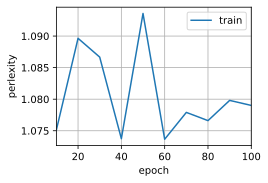

In [85]:
num_epochs, lr = 100, 0.1
# 使用顺序抽样
train(model, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

In [90]:
# pytorch简洁实现版本
num_inputs = len(vocab)
lsm_layer = nn.LSTM(num_inputs,num_hiddens)